# Refining the number of features

The goal of this notebook is to investigate the consequences of refining the number of features. First we limit the features to all numerical features and the set of categorical features for which we have a clear explanation in the dataset description. We figured that these are the most crucial features. We preprocess these according to the correct way. We find out that we do not have to impute any values, we only have to delete approximately a 1000 rows for missing values in the `B` column (both NaNs and 0 values for which there is no explanation). We then train a RandomForrestClassifier and a DecisionTreeClassifier. We found out using this that the performance barely decreased when we used these simpler models with a far smaller number of input features. Furthermore, this analysis let us investigate the feature importance. This allows us to refine the number of features even further. 

- Conclusions: despite the earlier reduction in the number of features, we see that the Random Forest model and even a simpler Decision Tree still hold up very well. We find that we can achieve a accuracy of 97.3% with these models. This is very good compared to the 98.6% which was achieved with all features. Furthermore, the feature importances show that we can still reduce the number of features even further. 

In the following **Notebook `5` - all final models.ipynb** we provide all models with this newly refined small set of features.

In [78]:
import pandas as pd
import re

# Load the Excel file
file_path = '../data/luiss_data_anonym.xlsx' # Update this path
df = pd.read_excel(file_path)

In [79]:
# Delete all rows for which IvaM is missing because this is the value we want to predict
df1 = df[~df.IvaM.isna()]

# Which features to use:
# Features with extra explanation --> extra important
categorical_features = ["A", "B", "Tdoc", "Iva", "IvaM", "TM", "TIva", "Caus"]
# Keep all numeric features
numeric_features = df1.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in categorical_features]  # don't add column double
# Total set of columns 
total_set_of_columns = categorical_features + numeric_features
df2 = df1[total_set_of_columns]

# delete all rows with over 50 percent missing values
missing_percentage = df2.isnull().sum() * 100 / len(df)
columns_to_drop = missing_percentage[missing_percentage > 50].index
columns_to_drop = list(columns_to_drop)
columns_to_drop.append("Unnamed: 0")
df_cleaned = df2.drop(columns=columns_to_drop)

C:\Users\20202034\AppData\Local\Temp\ipykernel_10408\1922747725.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\20202034\AppData\Local\Temp\ipykernel_10408\1922747725.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
df = df_cleaned

# Calculate number of NaNs per column
nans_per_column = df.isnull().sum()

# Calculate percentage of NaNs per column
percentage_nans_per_column = (df.isnull().sum() / len(df)) * 100

# Display as dataframe
nans_df = pd.DataFrame({'Number of NaNs': nans_per_column, 'Percentage of NaNs': percentage_nans_per_column})
nans_df

,Number of NaNs,Percentage of NaNs
A,0,0.0
Tdoc,0,0.0
Iva,0,0.0
IvaM,0,0.0
TM,0,0.0
TIva,0,0.0
Caus,0,0.0
Ateco,0,0.0
Importo,0,0.0
Conto,0,0.0


In [4]:
# special care for column B:
df = df[(df.B != 0) & ~df.B.isna()]  # besides missing values the 0s are a value that is not described in dataset description
df['B'] = df['B'].apply(lambda x: 1 if x in ['S', 'C', 'X'] else 0)  # S, C, X refer to Yes, N refers to No

C:\Users\20202034\AppData\Local\Temp\ipykernel_10408\1392990521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['B'] = df['B'].apply(lambda x: 1 if x in ['S', 'C', 'X'] else 0)  # S, C, X refer to Yes, N refers to No


In [81]:
df.nunique()  # Make sure we don't have columns with a single value -> no predictive power

A              13
Tdoc           11
Iva            24
IvaM           60
TM             12
TIva           12
Caus           38
Ateco         386
Importo     22487
Conto         703
ContoStd      365
CoDitta       725
dtype: int64

In [82]:
df

,A,Tdoc,Iva,IvaM,TM,TIva,Caus,Ateco,Importo,Conto,ContoStd,CoDitta
0,7,TD04,N2.2,374.0,7,12,12,476220,3.22,6625510,6625005,533
1,7,TD04,N2.2,374.0,7,12,12,476220,6.20,6625510,6625005,533
2,7,TD04,N2.2,374.0,7,12,12,476220,21.06,6625510,6625005,533
3,7,TD04,N2.2,374.0,7,12,12,476220,9.50,6625510,6625005,533
4,7,TD04,N2.2,374.0,7,12,12,476220,11.38,6625510,6625005,533
...,...,...,...,...,...,...,...,...,...,...,...,...
134432,7,TD01,N1,315.0,7,11,11,563000,-10.00,1840005,1840005,62
134433,7,TD01,N1,315.0,7,11,11,563000,120.00,1840005,1840005,62
134434,7,TD01,N1,315.0,7,11,11,563000,-150.00,1840005,1840005,62
134435,7,TD01,N1,315.0,7,11,11,563000,52.00,1840005,1840005,62


In [83]:
# We still find all 60 classes occurring in the dataset
category_counts = df['IvaM'].value_counts()
print(df.IvaM.nunique())
category_counts

60


IvaM
374.0    22129
324.0    20895
315.0    16589
312.0    11872
381.0    11061
22.0      7237
302.0     6522
310.0     6160
341.0     4426
326.0     4124
300.0     3771
325.0     3410
308.0     2628
317.0     2572
354.0     1960
377.0     1531
358.0     1104
375.0      844
340.0      626
314.0      616
307.0      576
371.0      544
336.0      439
306.0      425
346.0      365
370.0      230
372.0      192
309.0      189
10.0       175
304.0      152
323.0      144
622.0      106
345.0       68
347.0       67
301.0       65
376.0       29
356.0       23
322.0       20
318.0       11
379.0       11
2.0          8
327.0        5
311.0        5
35.0         5
222.0        4
329.0        3
399.0        3
331.0        3
321.0        3
303.0        3
722.0        3
334.0        2
350.0        2
316.0        2
367.0        2
355.0        1
23.0         1
110.0        1
339.0        1
369.0        1
Name: count, dtype: int64

In [84]:
# Check that fully inputed
nans_per_column = df.isnull().sum()

# Calculate percentage of NaNs per column
percentage_nans_per_column = (df.isnull().sum() / len(df)) * 100

# Display as dataframe
nans_df = pd.DataFrame({'Number of NaNs': nans_per_column, 'Percentage of NaNs': percentage_nans_per_column})

nans_df

,Number of NaNs,Percentage of NaNs
A,0,0.0
Tdoc,0,0.0
Iva,0,0.0
IvaM,0,0.0
TM,0,0.0
TIva,0,0.0
Caus,0,0.0
Ateco,0,0.0
Importo,0,0.0
Conto,0,0.0


Feature selection, and missing value removal is complete, now we need to preprocess the features in a correct manner

# Feature selection

In [86]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import seaborn as sns

In [87]:
# Split the dataset into features and target variable
X = df.drop('IvaM', axis=1)
y = df[['IvaM']]

In [88]:
# Encode target value
encoder = OneHotEncoder()
# Fit and transform the data, specifying sparse=False
encoded_data = encoder.fit_transform(y[['IvaM']]).toarray()
# Create a DataFrame with the encoded data and column names from the encoder
encoded_df_target = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['IvaM']))
encoded_df_target

,IvaM_2.0,IvaM_10.0,IvaM_22.0,IvaM_23.0,IvaM_35.0,IvaM_110.0,IvaM_222.0,IvaM_300.0,IvaM_301.0,IvaM_302.0,...,IvaM_372.0,IvaM_374.0,IvaM_375.0,IvaM_376.0,IvaM_377.0,IvaM_379.0,IvaM_381.0,IvaM_399.0,IvaM_622.0,IvaM_722.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
encoder = OneHotEncoder(drop="first")  
# If we have categories A, B, C -> the dummies only need B, C. If these are both 0, then A = 1. Therefore we drop first category
X[["A", "B", "TM"]] = X[["A", "B", "TM"]].astype(str)
categorical_features = ["A", "B", "Tdoc", "Iva", "TM"]
# Fit and transform the data, specifying sparse=False
encoded_data = encoder.fit_transform(X[categorical_features]).toarray()
# Create a DataFrame with the encoded data and column names from the encoder
encoded_df_cat = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))
encoded_df_cat.columns

Index(['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_A', 'A_E', 'A_G', 'A_N',
       'A_O', 'A_S', 'B_1', 'Tdoc_TD02', 'Tdoc_TD03', 'Tdoc_TD04', 'Tdoc_TD05',
       'Tdoc_TD06', 'Tdoc_TD17', 'Tdoc_TD24', 'Tdoc_TD25', 'Tdoc_TD26',
       'Tdoc_TD27', 'Iva_N2', 'Iva_N2.1', 'Iva_N2.2', 'Iva_N3', 'Iva_N3.1',
       'Iva_N3.2', 'Iva_N3.3', 'Iva_N3.4', 'Iva_N3.5', 'Iva_N3.6', 'Iva_N4',
       'Iva_N5', 'Iva_N6', 'Iva_N6.1', 'Iva_N6.2', 'Iva_N6.3', 'Iva_N6.4',
       'Iva_N6.5', 'Iva_N6.6', 'Iva_N6.7', 'Iva_N6.8', 'Iva_N6.9', 'Iva_N7',
       'TM_13', 'TM_14', 'TM_15', 'TM_16', 'TM_18', 'TM_19', 'TM_20', 'TM_3',
       'TM_4', 'TM_7', 'TM_8'],
      dtype='object')

In [72]:
len(['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_A', 'A_E', 'A_G', 'A_N',
       'A_O', 'A_S'])

12

In [13]:
# Standardize input features to have a standard deviation of 1
numeric_features = ['Ateco', 'Importo', 'Conto', 'ContoStd', '%RIT1', '%RIT2', 'CoDitta', 'TIva', 'Caus']
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X[numeric_features])
encoded_df_num = pd.DataFrame(scaled_X, columns=scaler.get_feature_names_out(numeric_features))
encoded_df_num.describe()

,Ateco,Importo,Conto,ContoStd,%RIT1,%RIT2,CoDitta,TIva,Caus
count,1.329690e+05,1.329690e+05,1.329690e+05,1.329690e+05,1.329690e+05,1.329690e+05,1.329690e+05,1.329690e+05,1.329690e+05
mean,6.946774e-17,6.412407e-19,2.496564e-16,-2.564963e-16,2.992456e-17,-2.618399e-18,-1.196983e-17,1.709975e-16,4.445935e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.497476e+00,-2.567495e+01,-3.972653e+00,-3.972569e+00,-1.144720e-01,-1.163046e-02,-4.607301e-01,-9.118480e-01,-2.835487e-01
25%,-2.191410e-01,-4.568546e-02,1.165766e-02,1.174341e-02,-1.144720e-01,-1.163046e-02,-4.339770e-01,-9.118480e-01,-2.835487e-01
50%,3.305280e-05,-4.421101e-02,1.504200e-02,1.512776e-02,-1.144720e-01,-1.163046e-02,-3.749357e-01,-9.118480e-01,-2.835487e-01
75%,3.526412e-02,-3.448077e-02,5.802618e-01,5.803409e-01,-1.144720e-01,-1.163046e-02,-1.853579e-01,1.061656e+00,6.635838e-02
max,2.642682e+00,2.229325e+02,2.920170e+00,2.584652e+00,4.319077e+01,9.163894e+01,3.833599e+00,1.349473e+01,1.171827e+01


# Split data

In [14]:
encoded_df_y = encoded_df_target
total_encoded_df_X = pd.concat([encoded_df_cat, encoded_df_num], axis=1)
X_train, X_test, y_train, y_test = train_test_split(total_encoded_df_X, encoded_df_y, test_size=0.2, random_state=42)

In [15]:
X_train

,A_2,A_3,A_4,A_5,A_6,A_7,A_A,A_E,A_G,A_N,...,TM_8,Ateco,Importo,Conto,ContoStd,%RIT1,%RIT2,CoDitta,TIva,Caus
1196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.019624,-0.045013,0.580605,0.580341,-0.114472,-0.01163,-0.215340,1.061656,0.066358
118309,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.018974,-0.029226,0.011658,0.011743,-0.114472,-0.01163,-0.374936,-0.911848,-0.283549
27986,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.489263,-0.061851,-2.738204,-2.738119,-0.114472,-0.01163,0.642604,1.061656,0.066358
129661,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.051325,0.017624,0.580255,0.580341,-0.114472,-0.01163,-0.442741,1.061656,0.066358
61940,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.017946,-0.044726,0.580599,0.580341,-0.114472,-0.01163,-0.459346,1.061656,0.066358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.003647,-0.028218,0.580255,0.580341,-0.114472,-0.01163,-0.454734,1.061656,0.066358
119879,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.018974,-0.045891,0.011658,0.011743,-0.114472,-0.01163,-0.374936,-0.911848,-0.283549
103694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.291460,0.001140,0.705351,0.705437,-0.114472,-0.01163,-0.457040,1.061656,0.066358
131932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.109026,-0.045602,0.587534,0.587335,-0.114472,-0.01163,-0.431671,1.061656,0.066358


# Train and evaluate models

In [16]:
def plot_feature_importance(model):
    # importances = self.model.feature_importances_ if 'feature_importances_' in self.model else self.model.coef_[0]
    importances = model.feature_importances_

    # Assuming the model is already trained and feature_importances obtained
    # Create a DataFrame for feature importances
    importances_df = pd.DataFrame(
        {
            "Features": X_train.columns,
            "Importances": importances,
        }
    )

    # Sort the DataFrame by importances
    importances_df = importances_df.sort_values(by="Importances", ascending=False)

    # Create the bar plot
    fig = px.bar(
        importances_df,
        x="Importances",
        y="Features",
        orientation="h",
        title="Feature Importances in Random Forest",
    )
    fig.show()
    return importances_df


def plot_decision_tree(model):
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=["1", "0"],
        proportion=True,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    modified_dot_data = re.sub(r'<br/>value = \[\[.*?\]\]>', '>', dot_data)
    graph = graphviz.Source(modified_dot_data)
    graph.render(
        "../assets/decision_tree_vis/decision_tree"
    )

In [17]:
model_rf = RandomForestClassifier(verbose=2, n_jobs=-1, random_state=42)
model_rf.fit(X_train, y_train)

# Making predictions on the test set
test_predictions = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
accuracy

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100building tree 14 of 100
building tree 15 of 100
building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.2s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100building tree 40 of 100

building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.4s finished


0.9735654658945627

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.4s finished


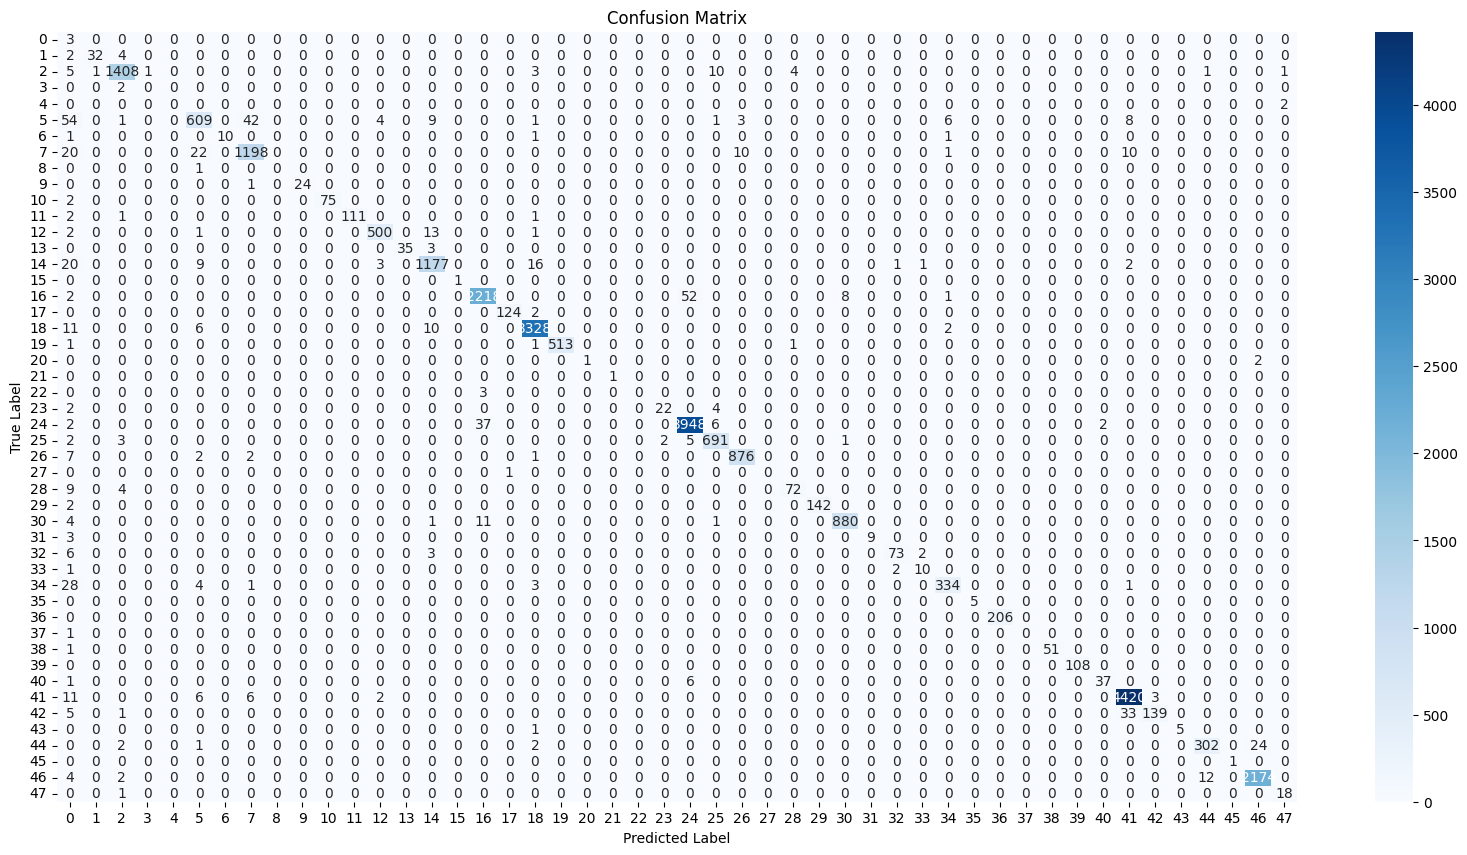

In [18]:
test_predictions = model_rf.predict(X_test)

y_pred2 = np.argmax(test_predictions, axis=1)
y_test2 = np.argmax(y_test.values, axis=1)

conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plotting the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
importances_numbers = plot_feature_importance(model_rf)
importances_numbers

,Features,Importances
57,Ateco,1.386256e-01
31,Iva_N3.5,9.850173e-02
59,Conto,8.815643e-02
63,CoDitta,8.140327e-02
60,ContoStd,8.099691e-02
...,...,...
20,Tdoc_TD25,1.482911e-05
21,Tdoc_TD26,1.411314e-05
8,A_G,2.285602e-06
14,Tdoc_TD03,3.075036e-07


In [70]:
importances_numbers["feature_agg"] = importances_numbers["Features"].apply(lambda x: x.split("_")[0])
importances_numbers.groupby("feature_agg").sum()["Importances"].to_frame().sort_values("Importances", ascending=False)

,Importances
feature_agg,
Iva,0.513433
TIva,0.111246
CoDitta,0.095645
Tdoc,0.062872
Importo,0.044129
Conto,0.040705
Ateco,0.035726
Caus,0.034576
ContoStd,0.030198


In [69]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Making predictions on the test set
test_predictions = model_dt.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
accuracy

0.973076633827179

In [53]:
importances_numbers = plot_feature_importance(model_dt)
importances_numbers

,Features,Importances
31,Iva_N3.5,0.135168
64,TIva,0.111246
63,CoDitta,0.095645
42,Iva_N6.7,0.083134
23,Iva_N2,0.056312
...,...,...
44,Iva_N6.9,0.000000
43,Iva_N6.8,0.000000
7,A_E,0.000000
41,Iva_N6.6,0.000000


In [68]:
importances_numbers["feature_agg"] = importances_numbers["Features"].apply(lambda x: x.split("_")[0])
importances_numbers.groupby("feature_agg").sum()["Importances"].to_frame().sort_values("Importances", ascending=False)

,Importances
feature_agg,
Iva,0.513433
TIva,0.111246
CoDitta,0.095645
Tdoc,0.062872
Importo,0.044129
Conto,0.040705
Ateco,0.035726
Caus,0.034576
ContoStd,0.030198


We can definitely get rid of %RIT1, %RIT2, B
Potentially get rid of A (removes 12 features), TM (removes 11 features)

could change: "TIva", "Caus", "Ateco", "Conto", "ContoStd", "CoDitta"

In [56]:
plot_decision_tree(model_dt)

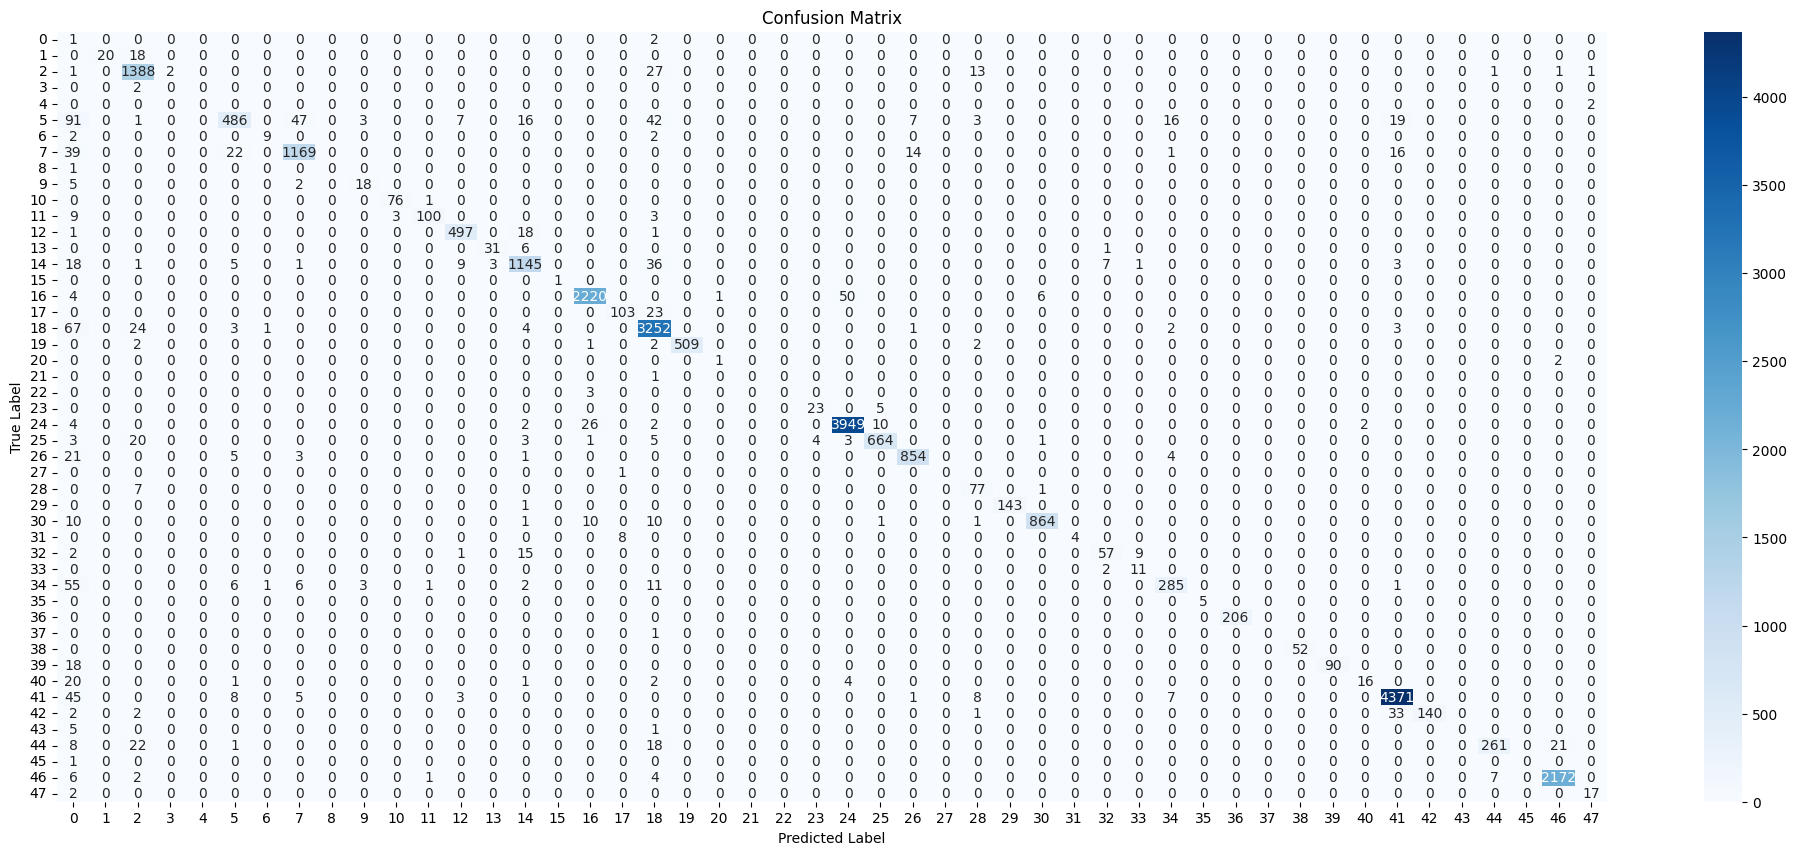

In [55]:
test_predictions = model_dt.predict(X_test)

y_pred2 = np.argmax(test_predictions, axis=1)
y_test2 = np.argmax(y_test.values, axis=1)

conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plotting the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()